In [3]:
import random
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange


In [5]:
# the file needs to be in the same directory as this notebook, to avoid cluttering the notebook with plotting code
from plotting_helper import *

# Accessing held out memorized data from a finetuned GPT2 classifier

In this section, we apply the same principle, training on a subset of the teachers memorized data, to a different token-based architecture (GPT-2 Classifier) with more classes (1000) and memorized sentences (6000).

We use a pre-trained GPT2 to memorize random sentences, which come in the form random triplets of numbers up to 1000, e.g. "234 300 3", and are randomly assigned to one out of 1000 classes.

In [14]:
# Dataset class: convert tuple of numbers to tokenized input
class TupleDataset(Dataset):
    def __init__(self, tuples, labels, tokenizer, max_len=10):
        self.tuples = tuples
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tuples)

    def __getitem__(self, idx):
        text = " ".join(map(str, self.tuples[idx]))
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        # Squeeze batch dim and return
        item = {k: v.squeeze(0) for k, v in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

Using the standard training pipeline, we finetune a GPT2 classifier (that would otherwise be e.g. used for sentiment classification) on the artificial unstructured data we created. After some epochs, the accuracy reaches almost perfect accuracy. We also use the standard tokenizer and do not impose a special structure on the sentences.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create random dataset
num_samples = 6000
tuple_len = 3
num_labels = 1000
tuples = [[random.randint(1, 1000) for _ in range(tuple_len)] for _ in range(num_samples)]
labels = [random.randint(0, num_labels-1) for _ in range(num_samples)]

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


dataset = TupleDataset(tuples, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Load GPT2ForSequenceClassification and resize token embeddings if pad token added
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)


model.train()

num_epochs = 100
pbar = range(num_epochs)
for epoch in pbar:
    total_loss = 0
    correct = 0
    total_samples = 0
    
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        preds = logits.argmax(axis=-1)
        correct += (preds == batch['labels']).sum().item()
        total_samples += batch['labels'].size(0)
    
    avg_epoch_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    #pbar.set_postfix(loss=f"{avg_epoch_loss:.4f}", acc=f"{accuracy:.2%}")
    print(accuracy)

model_save_path = "random_data_classification_teacher.pth"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

# Save dataset (the tuples and labels lists)
dataset_save_path = "dataset.pkl"
with open(dataset_save_path, "wb") as f:
    pickle.dump({"tuples": tuples, "labels": labels}, f)
print(f"Dataset saved to {dataset_save_path}")


Using device: cuda


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Exception ignored in: <function tqdm.__del__ at 0x7faf9a8e8280>
Traceback (most recent call last):
  File "/home/fbehrens/venvs/gpu-multitask/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/fbehrens/venvs/gpu-multitask/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7faf9a8e8280>
Traceback (most recent call last):
  File "/home/fbehrens/venvs/gpu-multitask/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/fbehrens/venvs/gpu-multitask/lib/python3.10/site-package

Model and tokenizer saved to random_data_classification_teacher.pth
Dataset saved to dataset.pkl


After successful training, when we memorize the sentences up to $>99\%$ accuracy, we extract the teacher's logits on its training data and create soft labels, again with temperature $\tau =20$. 

In [19]:
class DistillDataset(Dataset):
        def __init__(self, base_dataset, soft_labels, indices):
            self.inputs = [base_dataset[i] for i in indices]
            self.soft_labels = [soft_labels[i] for i in indices]

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            item = {k: v.clone() for k, v in self.inputs[idx].items()}
            item['soft_labels'] = self.soft_labels[idx]
            return item

temp = 20.0
teacher = model.eval() 
teacher_soft_labels = []

with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=12):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = teacher(**inputs)
        logits = outputs.logits
        teacher_soft_labels.extend(F.softmax(logits.detach().cpu() / temp, dim=-1))


This time we train different the students on different fractions of `dataset`, which we call $\rho = \{0.2,0.5,0.8\}$.
As in the 2D-example we evaluate the training accuracy and the test accuracy -- both of which are data that was memorized by the teacher. This time we leave out the validation, but that would again trivially be at $0.1\%$.

In [ ]:
student_epochs = 200
batch_size = 32

student_results = []

for training_size in [0.2,0.5,0.8]:
    test_size = 1 - training_size

    all_indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(all_indices, test_size=test_size, random_state=12)

    train_dataset = DistillDataset(dataset, teacher_soft_labels, train_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    student = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)
    student.config.pad_token_id = tokenizer.pad_token_id
    student.resize_token_embeddings(len(tokenizer))
    student.to(device)

    optimizer = AdamW(student.parameters(), lr=5e-4)
    student.train()
    criterion = torch.nn.CrossEntropyLoss()
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    pbar = range(student_epochs)
    for epoch in pbar:
        student.train()
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ['labels','soft_labels']}
            soft_targets = batch['soft_labels'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = student(**inputs)
            student_logits = outputs.logits
            
            loss = criterion(student_logits, soft_targets)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (student_logits.argmax(dim=-1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        train_accuracy =  total_correct / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_loss)

        student.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items()}
                labels = batch['labels'].to(device)

                outputs = student(**inputs)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(test_accuracy)
        
        #pbar.set_postfix(loss=f"{avg_loss:.4f}", train_acc=f"{train_accuracy:.2%}", test_acc=f"{test_accuracy:.2%}")

    student.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            logits = student(**inputs).logits
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f"Student accuracy on 20% held-out: {test_accuracy:.2%}")

    student_model_save_path = f"random_data_classification_student_rho={1-test_size:.2f}.pth"
    student.save_pretrained(student_model_save_path)
    
    student_results.append({
        'training_size': training_size,
        'test_size': test_size,
        'test_accuracy': test_accuracy,
        'train_accuracy': train_accuracy,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'train_losses': train_losses,
        'train_loss': avg_loss,
        'model': student,
        'tokenizer': tokenizer
    })

    print(f"Model and tokenizer saved to {student_model_save_path}")
    print('next')

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test size: 0.8, Test accuracy: 23.85%, Train accuracy: 99.92%
Test size: 0.5, Test accuracy: 58.63%, Train accuracy: 99.80%
Test size: 0.19999999999999996, Test accuracy: 72.83%, Train accuracy: 99.79%


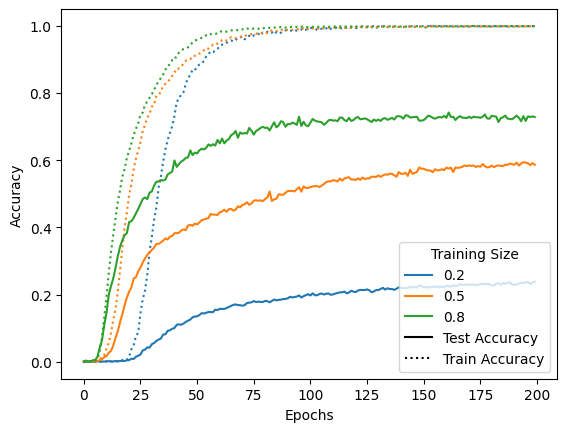

In [14]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for color, res in zip(colors,student_results):
    print(f"Test size: {res['test_size']}, Test accuracy: {res['test_accuracy']:.2%}, Train accuracy: {res['train_accuracy']:.2%}")
    plt.plot(res['train_accuracies'], c=color, linestyle='dotted')
    plt.plot(res['test_accuracies'], c=color)
    plt.plot([],[],c=color, label=res['training_size'])
    
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot([],[],c='black', label='test accuracy')
plt.plot([],[],c='black', linestyle='dotted', label='train accuracy')
plt.legend(title=r'$\rho$')
plt.savefig('GPT2_accuracy.png', bbox_inches='tight')

While the accuracy of random guessing should be $0.1\%$ in expectation, as there are $1000$ classes, training on $80\%$ of the data leads to an accuracy of *more than $60\%$* on the held out data.
Here the soft labels are containing a lot of information that is used by the student. 

Even though we can demonstrate this phenomenon well on GPT2, larger scale experiments that go beyond the three models we trained are costly.
In our final experiment we therefore turn to ReLU MLPs with a single hidden layer.